In [1]:
%matplotlib inline
import math
import openmc

In [2]:
fuel = openmc.Material(name="uo2")
fuel.add_element("U", 1, percent_type="ao", enrichment=4.25)
fuel.add_element("O", 2)
fuel.set_density("g/cc", 10.4)
clad = openmc.Material(name="clad")
clad.add_element("Zr", 1)
clad.set_density("g/cc", 6)
water = openmc.Material(name="water")
water.add_element("O", 1)
water.add_element("H", 2)
water.set_density("g/cc", 1.0)
water.add_s_alpha_beta("c_H_in_H2O")
materials = openmc.Materials([fuel, clad, water])

In [3]:
radii = [0.42, 0.45]

pin_surfaces = [openmc.ZCylinder(r=r) for r in radii]
pin_univ = openmc.model.pin(pin_surfaces, materials)

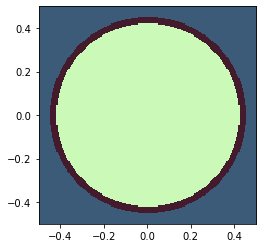

In [4]:
pin_univ.plot()

In [5]:
bound_box = openmc.rectangular_prism(0.62, 0.62, boundary_type="reflective")
root_cell = openmc.Cell(fill=pin_univ, region=bound_box)
root_univ = openmc.Universe(cells=[root_cell])
geometry = openmc.Geometry(root_univ)

In [6]:
settings = openmc.Settings()
settings.particles = 1000
settings.inactive = 10
settings.batches = 50

In [7]:
geometry.export_to_xml()
settings.export_to_xml()

In [8]:
fuel.volume = math.pi * radii[0] ** 2
materials.export_to_xml()

In [9]:
import openmc.deplete

In [10]:
chain = openmc.deplete.Chain.from_xml("chain_casl.xml")

In [11]:
chain.nuclide_dict

OrderedDict([('B10', 0),
             ('B11', 1),
             ('O16', 2),
             ('Br81', 3),
             ('Br82', 4),
             ('Kr82', 5),
             ('Kr83', 6),
             ('Kr84', 7),
             ('Kr85', 8),
             ('Kr86', 9),
             ('Sr89', 10),
             ('Sr90', 11),
             ('Y89', 12),
             ('Y90', 13),
             ('Y91', 14),
             ('Zr91', 15),
             ('Zr93', 16),
             ('Zr95', 17),
             ('Zr96', 18),
             ('Nb95', 19),
             ('Mo95', 20),
             ('Mo96', 21),
             ('Mo97', 22),
             ('Mo98', 23),
             ('Mo99', 24),
             ('Mo100', 25),
             ('Tc99', 26),
             ('Tc99_m1', 27),
             ('Tc100', 28),
             ('Ru100', 29),
             ('Ru101', 30),
             ('Ru102', 31),
             ('Ru103', 32),
             ('Ru104', 33),
             ('Ru105', 34),
             ('Ru106', 35),
             ('Rh102', 36),
    

In [12]:
operator = openmc.deplete.Operator(geometry, settings, "chain_casl.xml")

In [13]:
power = 174

In [14]:
time_steps = [30 * 24 * 60 * 60] * 6

In [15]:
integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power)

In [16]:
integrator.integrate()

In [17]:
!ls *.h5

depletion_results.h5	 openmc_simulation_n3.h5  statepoint.50.h5
openmc_simulation_n0.h5  openmc_simulation_n4.h5  summary.h5
openmc_simulation_n1.h5  openmc_simulation_n5.h5
openmc_simulation_n2.h5  openmc_simulation_n6.h5


In [18]:
results = openmc.deplete.ResultsList.from_hdf5("./depletion_results.h5")

In [19]:
time, k = results.get_eigenvalue()
time /= (24 * 60 * 60)  # convert back to days from seconds
k

array([[0.77338073, 0.00280439],
       [0.77815358, 0.00253803],
       [0.78822502, 0.00256827],
       [0.80179777, 0.00262704],
       [0.82053249, 0.00283678],
       [0.82843588, 0.00224567],
       [0.84703211, 0.00235475]])

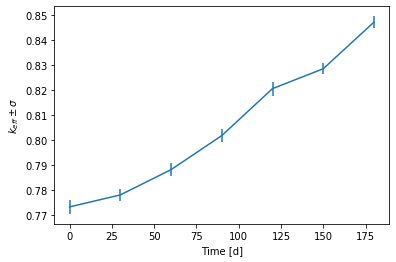

In [20]:
from matplotlib import pyplot
pyplot.errorbar(time, k[:, 0], yerr=k[:, 1])
pyplot.xlabel("Time [d]")
pyplot.ylabel("$k_{eff}\pm \sigma$");